### Model Fitting using Training set sampled images

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import glob
import cv2

import os
import sys  
import re
sys.path.insert(0, '../dip_utils')

from matrix_utils import arr_info
from vis_utils import (vis_rgb_cube,
                       vis_hists,
                       vis_pair, 
                       vis_triple)
%run watershed.ipynb
%run calibrate.ipynb
%run greyscale.ipynb
%run image_stacking.ipynb
%run whitep_elimination.ipynb

In [2]:
path = '../sampled_images'
dest = '../stacked_new'

In [3]:
files = glob.glob('%s/*' % dest)
for f in files:
    os.remove(f)

In [4]:
image_stacking(path, dest)

In [5]:
clear = '../stacked_new/NTU0.jpg'

In [6]:
img_lib = []

In [7]:
for dic in os.listdir(dest):
    if dic != '.ipynb_checkpoints':
        img_lib.append(dic)

In [8]:
markers_lib = dict()
for img in img_lib:
    markers = watershed(dest, img)
    markers_lib[img] = markers

In [9]:
bottom_lib = dict()
left_lib = dict()

In [10]:
# Acquire the bottom and the leftmost point of the ROI
for key in markers_lib:
    bottom = np.where(markers_lib[key]==1)[0].max()
    bottom_lib[key] = bottom
    left = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].min()
    left_lib[key] = left

In [11]:
# Some threshold values
vert_thres = 500
horz_thres = 50
length = 80
dist = 350

In [12]:
# Avoid Extracting incorrect ROI
count = []
for key in markers_lib:
    c = 0
    while markers_lib[key][bottom_lib[key]-vert_thres, left_lib[key]+horz_thres] == 1:
        left_lib[key] += horz_thres
        c += 1
    count.append(c)

In [13]:
count = np.array(count)
recall = 1 - np.mean(np.sum(count) / np.size(count))
recall

0.8421052631578947

In [14]:
# Calibration
calibrated = {}
for img in img_lib:
    org = plt.imread(os.path.join(dest, img))
    org = lab_trans(clear, org)
    calibrated[img] = org

In [15]:
greyscale = {}
for img in img_lib:
    grey = calibrated[img]
    grey = to_single_channel(grey)
    greyscale[img] = grey

In [16]:
# x_left represents the ROI of the reference, while x_right represents the ROI of the sample
x_left = []
x_right = []
y_left = []
y_right = []

In [17]:
for key in greyscale:
    x = []
    x1 = []
    y = []
    y1 = []
    for i in range(bottom_lib[key], bottom_lib[key]-vert_thres, -1):
        x.append(i)
        y.append(np.mean(greyscale[key][i-1:i, left_lib[key]+horz_thres:left_lib[key]+horz_thres+length]))
    x_left.append(x)
    y_left.append(y)
    for i in range(bottom_lib[key], bottom_lib[key]-vert_thres, -1):
        x1.append(i)
        y1.append(np.mean(greyscale[key][i-1:i, left_lib[key]+horz_thres+dist:
                                         left_lib[key]+horz_thres+dist+length]))
    x_right.append(x1)
    y_right.append(y1)

In [18]:
x_left = np.array(x_left)
x_right = np.array(x_right)
y_left = np.array(y_left)
y_right = np.array(y_right)

In [19]:
arr_info(x_left), arr_info(y_left)

(((38, 500), dtype('int64'), 1201, 1700),
 ((38, 500), dtype('float64'), 13.2125, 179.05))

In [35]:
x_left

array([[1700, 1699, 1698, ..., 1203, 1202, 1201],
       [1700, 1699, 1698, ..., 1203, 1202, 1201],
       [1700, 1699, 1698, ..., 1203, 1202, 1201],
       ...,
       [1700, 1699, 1698, ..., 1203, 1202, 1201],
       [1700, 1699, 1698, ..., 1203, 1202, 1201],
       [1700, 1699, 1698, ..., 1203, 1202, 1201]])

In [20]:
# plot the ratio with respect to NTU
num = []
for img in img_lib:
    img = img.replace('_', '.')
    a = img.split('NTU')
    a = [b.split('.jpg') for b in a]
    for item in a:
        item.remove("")
    num.append(a)

In [21]:
NTU = []
for i in num:
    for j in i:
        if len(j) != 0:
            NTU.append(float(j[0]))

In [22]:
diff = {}
for i in range(x_left.shape[0]):
    diff[img_lib[i]] = np.mean(y_right[i] - y_left[i])
diff

{'NTU85.jpg': 23.386875,
 'NTU190.jpg': 33.40455,
 'NTU156.jpg': 29.965,
 'NTU41.jpg': 16.243575,
 'NTU87_5.jpg': 24.5965,
 'NTU44_2.jpg': 22.6719,
 'NTU76_1.jpg': 22.094574999999995,
 'NTU0.jpg': 3.9796750000000003,
 'NTU290.jpg': 46.628525,
 'NTU113.jpg': 26.873,
 'NTU69_9.jpg': 20.1203,
 'NTU182.jpg': 33.91975,
 'NTU142.jpg': 34.69364999999999,
 'NTU36_5.jpg': 15.109174999999999,
 'NTU16_1.jpg': 9.99935,
 'NTU167.jpg': 32.586875,
 'NTU108.jpg': 25.412125,
 'NTU208.jpg': 35.679300000000005,
 'NTU250.jpg': 38.1714,
 'NTU212.jpg': 35.08435,
 'NTU235.jpg': 37.588175,
 'NTU281.jpg': 40.301725000000005,
 'NTU266.jpg': 38.01685,
 'NTU256.jpg': 37.82795,
 'NTU145.jpg': 27.88685,
 'NTU126.jpg': 30.984775000000003,
 'NTU129.jpg': 30.065875,
 'NTU135.jpg': 31.460525,
 'NTU50.jpg': 19.7184,
 'NTU33_3.jpg': 15.992875,
 'NTU24_5.jpg': 18.9902,
 'NTU123.jpg': 26.225799999999996,
 'NTU224.jpg': 36.93085000000001,
 'NTU308.jpg': 54.7026,
 'NTU272.jpg': 42.64827499999999,
 'NTU341.jpg': 55.817675,
 '

In [23]:
diff_c = diff['NTU0.jpg']
for key in diff:
    diff[key] -= diff_c

In [24]:
pixel_intensity = []
for key in diff:
    pixel_intensity.append(diff[key])
pixel_intensity = np.array(pixel_intensity)

In [25]:
sorted(diff.items(), key=lambda x:x[0])

[('NTU0.jpg', 0.0),
 ('NTU108.jpg', 21.43245),
 ('NTU113.jpg', 22.893325),
 ('NTU123.jpg', 22.246124999999996),
 ('NTU126.jpg', 27.005100000000002),
 ('NTU129.jpg', 26.086199999999998),
 ('NTU135.jpg', 27.48085),
 ('NTU142.jpg', 30.71397499999999),
 ('NTU145.jpg', 23.907175),
 ('NTU156.jpg', 25.985325),
 ('NTU167.jpg', 28.6072),
 ('NTU16_1.jpg', 6.019674999999999),
 ('NTU182.jpg', 29.940075),
 ('NTU190.jpg', 29.424875),
 ('NTU208.jpg', 31.699625000000005),
 ('NTU212.jpg', 31.104675),
 ('NTU224.jpg', 32.951175000000006),
 ('NTU235.jpg', 33.6085),
 ('NTU24_5.jpg', 15.010525000000001),
 ('NTU250.jpg', 34.191725),
 ('NTU256.jpg', 33.848275),
 ('NTU266.jpg', 34.037175),
 ('NTU272.jpg', 38.66859999999999),
 ('NTU281.jpg', 36.322050000000004),
 ('NTU290.jpg', 42.64885),
 ('NTU308.jpg', 50.722925),
 ('NTU315.jpg', 50.03490000000001),
 ('NTU330.jpg', 53.01305),
 ('NTU33_3.jpg', 12.0132),
 ('NTU341.jpg', 51.838),
 ('NTU36_5.jpg', 11.129499999999998),
 ('NTU41.jpg', 12.2639),
 ('NTU44_2.jpg', 18.

In [26]:
NTU = np.array(NTU)

In [27]:
df = pd.DataFrame({'pixel intensity': pixel_intensity,
                   'turbidity (NTU)': NTU})

In [28]:
#fit simple linear regression model
model = ols('NTU ~ pixel_intensity', data=df).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    NTU   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     453.9
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           5.34e-22
Time:                        11:22:10   Log-Likelihood:                -178.69
No. Observations:                  38   AIC:                             361.4
Df Residuals:                      36   BIC:                             364.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -50.4419     10.818     

Text(0.5, 1.0, 'Pixel Intensity V.S. NTU Value')

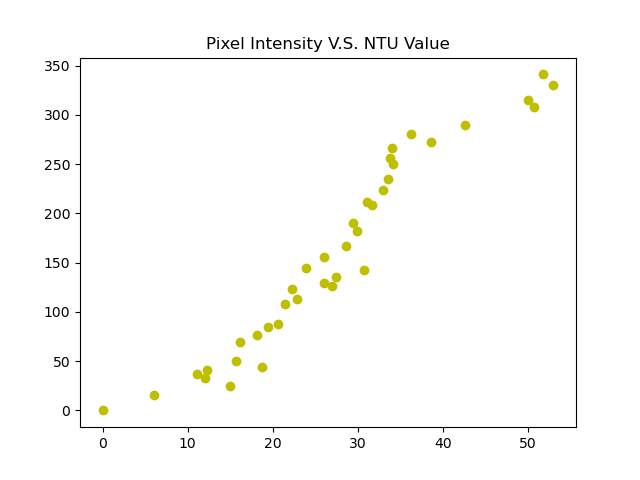

In [29]:
plt.figure()
plt.plot(pixel_intensity, NTU, 'yo')
plt.title('Pixel Intensity V.S. NTU Value')

In [30]:
theta = np.polyfit(pixel_intensity, NTU, 1)

In [31]:
plt.plot(pixel_intensity, theta[0]*pixel_intensity + theta[1])

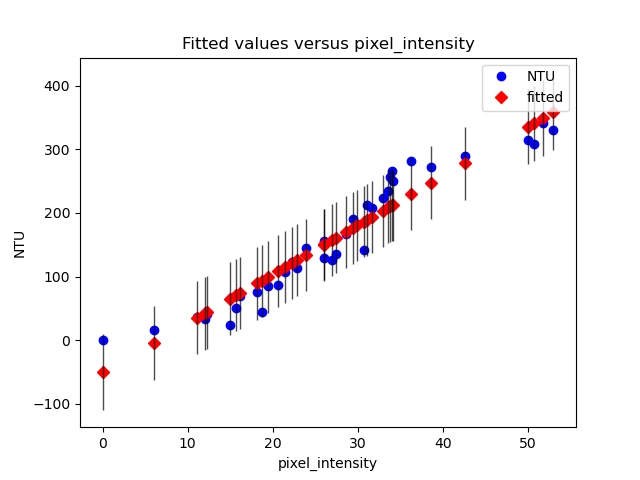

In [32]:
# Figure 8
#define figure size
fig, ax = plt.subplots()

#produce regression plots
#fig = sm.graphics.plot_regress_exog(model, 'pixel_intensity', fig=fig)
fig = sm.graphics.plot_fit(model, 'pixel_intensity', ax=ax)
plt.savefig('../assets/model_fit.pdf', dpi=600)

In [33]:
f = open('../assets/theta.txt', 'w')
f.write(str(diff_c))
f.write('\n')
f.write(str(theta[0]))
f.write('\n')
f.write(str(theta[1]))
f.close()